In [84]:
%cd /home/ira/code/projects/nn-play

import argparse
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.nn.functional as F

from simple_container import DataContainer

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ira/code/projects/nn-play


In [ ]:
# data_train = DataContainer('data-toy/single-train.pt', batch_size=128)
data_train = DataContainer('data-balls/balls-train.pt', batch_size=32,
                          ep_len_read=100)
# data_valid = DataContainer('data-toy/single-valid.pt', batch_size=128)
data_valid = DataContainer('data-balls/balls-valid.pt', batch_size=32,
                          ep_len_read=100)


In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)


In [7]:
a = data_train.get_batch_episodes()

In [8]:
i = 0

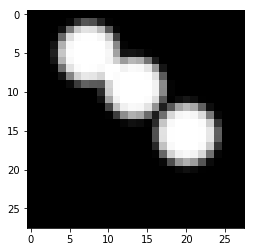

In [83]:
plt.imshow(a[0,i,:,:], cmap='gray')
i += 1

In [93]:
model = Net()
ims = data_train.get_batch_images()
# ims = Variable(torch.from_numpy(np.random.random((3, 28, 28))))

In [98]:
ims.shape

(32, 28, 28)

In [95]:
ims.size()

TypeError: 'int' object is not callable

In [96]:
a = model.forward(ims)

TypeError: argument 0 is not a Variable

In [ ]:


if args.cuda:
    model.cuda()

reconstruction_function = nn.BCELoss()
reconstruction_function.size_average = False


def loss_function(recon_x, x, mu, logvar):
    BCE = reconstruction_function(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)

    return BCE + KLD


optimizer = optim.Adam(model.parameters(), lr=1e-3)


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if args.cuda:
            data = data.cuda()
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.data[0]
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.data[0] / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    for data, _ in test_loader:
        if args.cuda:
            data = data.cuda()
        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).data[0]

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))


for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)